In [1]:
import torch
torch.cuda.empty_cache()
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

e:\Python_Virtual_Environments\DS203_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
x = torch.tensor([1.0], device='cuda')  # Should not raise error

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
df = pd.read_csv('processed_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Session_Summary  667 non-null    object
 1   tokens           667 non-null    object
 2   words_count      667 non-null    int64 
 3   sentence_count   667 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 21.0+ KB


In [4]:
tokenizer = AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)
model = AutoModel.from_pretrained(
    'jinaai/jina-embeddings-v2-base-en',
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map='auto'
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise RuntimeError("CUDA (GPU) not available. Aborting to prevent CPU crash.")

model = model.to(device)
model.eval()

JinaBertModel(
  (embeddings): JinaBertEmbeddings(
    (word_embeddings): Embedding(30528, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): JinaBertEncoder(
    (layer): ModuleList(
      (0-11): 12 x JinaBertLayer(
        (attention): JinaBertAttention(
          (self): JinaBertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): JinaBertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )

## Analysing Similarity between session summaries

In [5]:
# Mean pooling function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return (token_embeddings * input_mask_expanded).sum(1) / input_mask_expanded.sum(1)

In [6]:

# Tokenize and embed full texts using Jina model
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = mean_pooling(outputs, inputs['attention_mask'])
    return embedding.cpu().numpy()[0]

In [7]:

# Pick two summary indices
idx1, idx2 = 2, 210

# Full texts for embedding
text1_full = df['Session_Summary'][idx1]
text2_full = df['Session_Summary'][idx2]

# Shortened display version
text1_display = ' '.join(text1_full.split()[:200])
text2_display = ' '.join(text2_full.split()[:200])


# Embeddings
emb1 = get_embedding(text1_full)
emb2 = get_embedding(text2_full)

# Similarity metrics
cos_sim = cosine_similarity([emb1], [emb2])[0][0]
eu_dist = norm(emb1 - emb2)

# Output
print(" Summary 1 (truncated):\n", text1_display, "\n")
print(" Summary 2 (truncated):\n", text2_display, "\n")
print(f" Cosine Similarity: {cos_sim:.4f}")
print(f" Euclidean Distance: {eu_dist:.4f}")


 Summary 1 (truncated):
 population and sample were further discussed upon. sample is a good and representative part of the population. sample is used to predict/estimate the population. attributes and operations such as count, mode , median, mean, std. deviation , variance , add, multiply, divide and subtract. different level of measurement were classified on the basis of these attributes and operations. population has parameter(s) while sample has statistic. we estimate parameters on the basis of these statistic. linear data model was discussed upon from the sales vs advt. expenditure . any model can be fitted upon any set of data but it might not be the best fit. even a point can be considered a model although a naive model. as sample size increases the estimation of parameters gets better and better. based on th sample a slr can be fit with the equation y=î²o+î²1 , where î²o is the bias in the data , as the sample size gets closer and closer to the population this bias reduces. bia

In [8]:
# Pick two summary indices
idx1, idx2 = 10, 22

# Full texts for embedding
text1_full = df['Session_Summary'][idx1]
text2_full = df['Session_Summary'][idx2]

# Shortened display version
text1_display = ' '.join(text1_full.split()[:200])
text2_display = ' '.join(text2_full.split()[:200])

# Embeddings
emb1 = get_embedding(text1_full)
emb2 = get_embedding(text2_full)

# Similarity metrics
cos_sim = cosine_similarity([emb1], [emb2])[0][0]
eu_dist = norm(emb1 - emb2)

# Print output
print(" Summary 1 (truncated):\n", text1_display, "\n")
print(" Summary 2 (truncated):\n", text2_display, "\n")
print(f" Cosine Similarity: {cos_sim:.4f}")
print(f" Euclidean Distance: {eu_dist:.4f}")


 Summary 1 (truncated):
 problem with heatmap is that they don't capture sufficient information but they play important role when we have multiple parameters and it is not feasible to plot all parameters therefore heatmap helps in pair wise analysis.variance influence factor explain a parameter based other all other parameters excluding itself cif is xi=f( xj not equals xi ) indentify the vif of the features of the vif is greater than threshold then remove it principle component analysis is an application of singular value decomposition principle component are necessarily orthogonal to each other and can be equal to the dimension of the data but if we have for say 10 principle component we can decide which parameters we will choose to continue with if we have 2 dimensional data and we do pca then it may get converted to one dimension hence help in reducing the dimensionality of the data pcs are the weighted sum of all the parameters and the weights are known as loading in general vif n

In [9]:
# Pick one summary index
idx1 = 10

# Full texts for embedding
text1_full = df['Session_Summary'][idx1]
text2_full = "Sport is a form of physical activity or game. Often competitive and organized, sports use, maintain, or improve physical ability and skills. They also provide enjoyment to participants and, in some cases, entertainment to spectators.[2] Many sports exist, with different participant numbers, some are done by a single person with others being done by hundreds. Most sports take place either in teams or competing as individuals. Some sports allow a 'tie' or 'draw', in which there is no single winner; others provide tie-breaking methods to ensure one winner. A number of contests may be arranged in a tournament format, producing a champion. Many sports leagues make an annual champion by arranging games in a regular sports season, followed in some cases by playoffs."

# Shortened display version
text1_display = ' '.join(text1_full.split()[:200])
text2_display = ' '.join(text2_full.split()[:200])

# Embeddings
emb1 = get_embedding(text1_full)
emb2 = get_embedding(text2_full)

# Similarity metrics
cos_sim = cosine_similarity([emb1], [emb2])[0][0]
eu_dist = norm(emb1 - emb2)

# Print output
print(" Summary 1 (truncated):\n", text1_display, "\n")
print(" Summary 2 (truncated):\n", text2_display, "\n")
print(f" Cosine Similarity: {cos_sim:.4f}")
print(f" Euclidean Distance: {eu_dist:.4f}")


 Summary 1 (truncated):
 problem with heatmap is that they don't capture sufficient information but they play important role when we have multiple parameters and it is not feasible to plot all parameters therefore heatmap helps in pair wise analysis.variance influence factor explain a parameter based other all other parameters excluding itself cif is xi=f( xj not equals xi ) indentify the vif of the features of the vif is greater than threshold then remove it principle component analysis is an application of singular value decomposition principle component are necessarily orthogonal to each other and can be equal to the dimension of the data but if we have for say 10 principle component we can decide which parameters we will choose to continue with if we have 2 dimensional data and we do pca then it may get converted to one dimension hence help in reducing the dimensionality of the data pcs are the weighted sum of all the parameters and the weights are known as loading in general vif n

In [10]:
# Pick one summary index
idx1 = 10

# Full texts for embedding
text1_full = df['Session_Summary'][idx1]
text2_full = "Economics is a social science that studies the production, distribution, and consumption of goods and services. Economics focuses on the behaviour and interactions of economic agents and how economies work. Microeconomics analyses what is viewed as basic elements within economies, including individual agents and markets, their interactions, and the outcomes of interactions. Individual agents may include, for example, households, firms, buyers, and sellers. Macroeconomics analyses economies as systems where production, distribution, consumption, savings, and investment expenditure interact; and the factors of production affecting them, such as: labour, capital, land, and enterprise, inflation, economic growth, and public policies that impact these elements. It also seeks to analyse and describe the global economy."

# Shortened display version
text1_display = ' '.join(text1_full.split()[:200])
text2_display = ' '.join(text2_full.split()[:200])

# Embeddings
emb1 = get_embedding(text1_full)
emb2 = get_embedding(text2_full)

# Similarity metrics
cos_sim = cosine_similarity([emb1], [emb2])[0][0]
eu_dist = norm(emb1 - emb2)

# Print output
print(" Summary 1 (truncated):\n", text1_display, "\n")
print(" Summary 2 (truncated):\n", text2_display, "\n")
print(f" Cosine Similarity: {cos_sim:.4f}")
print(f" Euclidean Distance: {eu_dist:.4f}")


 Summary 1 (truncated):
 problem with heatmap is that they don't capture sufficient information but they play important role when we have multiple parameters and it is not feasible to plot all parameters therefore heatmap helps in pair wise analysis.variance influence factor explain a parameter based other all other parameters excluding itself cif is xi=f( xj not equals xi ) indentify the vif of the features of the vif is greater than threshold then remove it principle component analysis is an application of singular value decomposition principle component are necessarily orthogonal to each other and can be equal to the dimension of the data but if we have for say 10 principle component we can decide which parameters we will choose to continue with if we have 2 dimensional data and we do pca then it may get converted to one dimension hence help in reducing the dimensionality of the data pcs are the weighted sum of all the parameters and the weights are known as loading in general vif n

In [11]:
# Full texts for embedding
text1_full = "I like playing Cricket"
text2_full = "I don't like playing cricket"

# Shortened display version
text1_display = ' '.join(text1_full.split()[:200])
text2_display = ' '.join(text2_full.split()[:200])

# Embeddings
emb1 = get_embedding(text1_full)
emb2 = get_embedding(text2_full)

# Similarity metrics
cos_sim = cosine_similarity([emb1], [emb2])[0][0]
eu_dist = norm(emb1 - emb2)

# Print output
print(" Summary 1 (truncated):\n", text1_display, "\n")
print(" Summary 2 (truncated):\n", text2_display, "\n")
print(f" Cosine Similarity: {cos_sim:.4f}")
print(f" Euclidean Distance: {eu_dist:.4f}")

 Summary 1 (truncated):
 I like playing Cricket 

 Summary 2 (truncated):
 I don't like playing cricket 

 Cosine Similarity: 0.8866
 Euclidean Distance: 6.9609


## Getting Embeddings for Summaries

In [12]:
# Convert summaries to embeddings using mean pooling
all_embeddings = []
for text in tqdm(df['Session_Summary'], desc="Embedding summaries"):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=8192)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        token_embeddings = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
        attention_mask = inputs['attention_mask'].unsqueeze(-1)  # (batch_size, seq_len, 1)

        masked_embeddings = token_embeddings * attention_mask
        sum_embeddings = masked_embeddings.sum(dim=1)
        sum_mask = attention_mask.sum(dim=1)
        emb = (sum_embeddings / sum_mask).squeeze().cpu().numpy()

        all_embeddings.append(emb)
torch.cuda.empty_cache()

# Create new DataFrame with summaries and embeddings
df_embed = pd.DataFrame({
    'Session_Summary': df['Session_Summary'],
    'Embedding': all_embeddings
})

# Export to CSV (convert embedding to list of floats for CSV compatibility)
df_embed['Embedding'] = df_embed['Embedding'].apply(lambda x: ','.join(map(str, x)))
df_embed.to_csv("jina_summary_embeddings.csv", index=False)


Embedding summaries: 100%|██████████| 667/667 [00:14<00:00, 45.94it/s]


## Exploring the Embeddings

C:\Users\pradh\AppData\Local\Temp\ipykernel_5124\3511737839.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


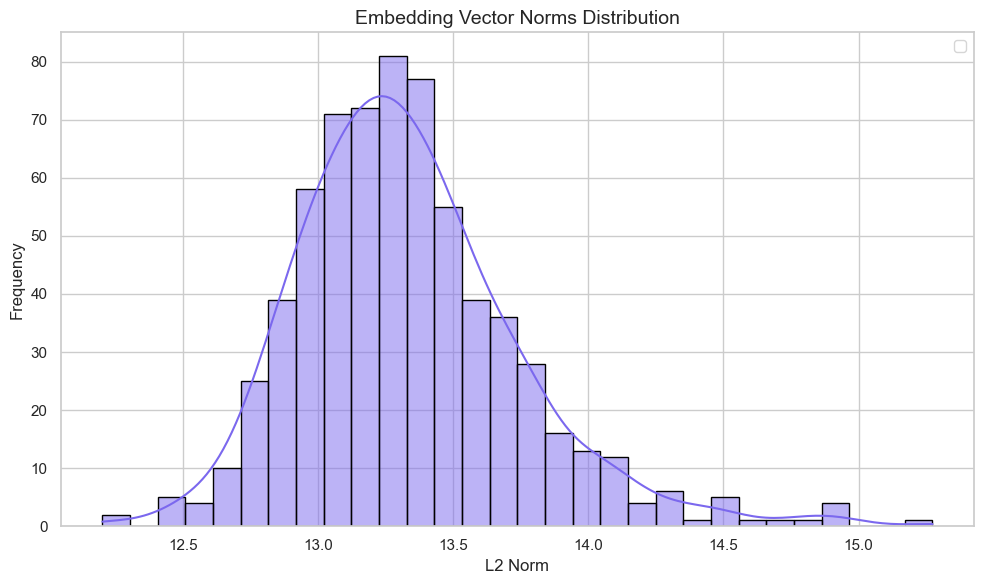

In [13]:
# Ensure seaborn style
sns.set_theme(style="whitegrid")

# Convert to array if needed
embeddings_array = np.array(all_embeddings)
norms = np.linalg.norm(embeddings_array, axis=1)

# Compute stats
mean_norm = np.mean(norms)
std_norm = np.std(norms)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(norms, bins=30, kde=True, color='mediumslateblue', edgecolor='black')

plt.title("Embedding Vector Norms Distribution", fontsize=14)
plt.xlabel("L2 Norm", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
summary_idx = 10
query_emb = embeddings_array[summary_idx]

# Compute L2 (Euclidean) distances
distances = np.linalg.norm(embeddings_array - query_emb, axis=1)

# Get indices of top 10 closest (excluding itself)
top_indices = np.argsort(distances)[1:6]

# Display
print(f"\n🔍 Query Summary (Index {summary_idx}):\n")
print(df.loc[summary_idx, 'Session_Summary'][:300], "...")  # truncated for display

print("\n📚 Top 5 Similar Summaries:\n")
for rank, idx in enumerate(top_indices, 1):
    print(f"🔹 Rank {rank} | Index {idx} | Distance: {distances[idx]:.4f}")
    print(df.loc[idx, 'Session_Summary'][:300], "...\n")  # truncated for neatness


🔍 Query Summary (Index 10):

problem with heatmap is that they don't capture sufficient information but they play important role when we have multiple parameters and it is not feasible to plot all parameters therefore heatmap helps in pair wise analysis.variance influence factor explain a parameter based other all other paramet ...

📚 Top 5 Similar Summaries:

🔹 Rank 1 | Index 590 | Distance: 4.3750
we continued with the correlation problems. we observed the heat maps for perfectly co-related data and partially correlated data. heatmaps are more coherent if they are created after sorting the data. when we calculate vif, we do not process the values of y but only x-values. vif is simply the func ...

🔹 Rank 2 | Index 533 | Distance: 4.6992
heatmaps are useful visualization tools for pairwise analysis when plotting all parameters individually is impractical, although they lack detailed numeric insights. variance inflation factor (vif) helps detect multicollinearity by measuring how much

## Principal Component Analysis

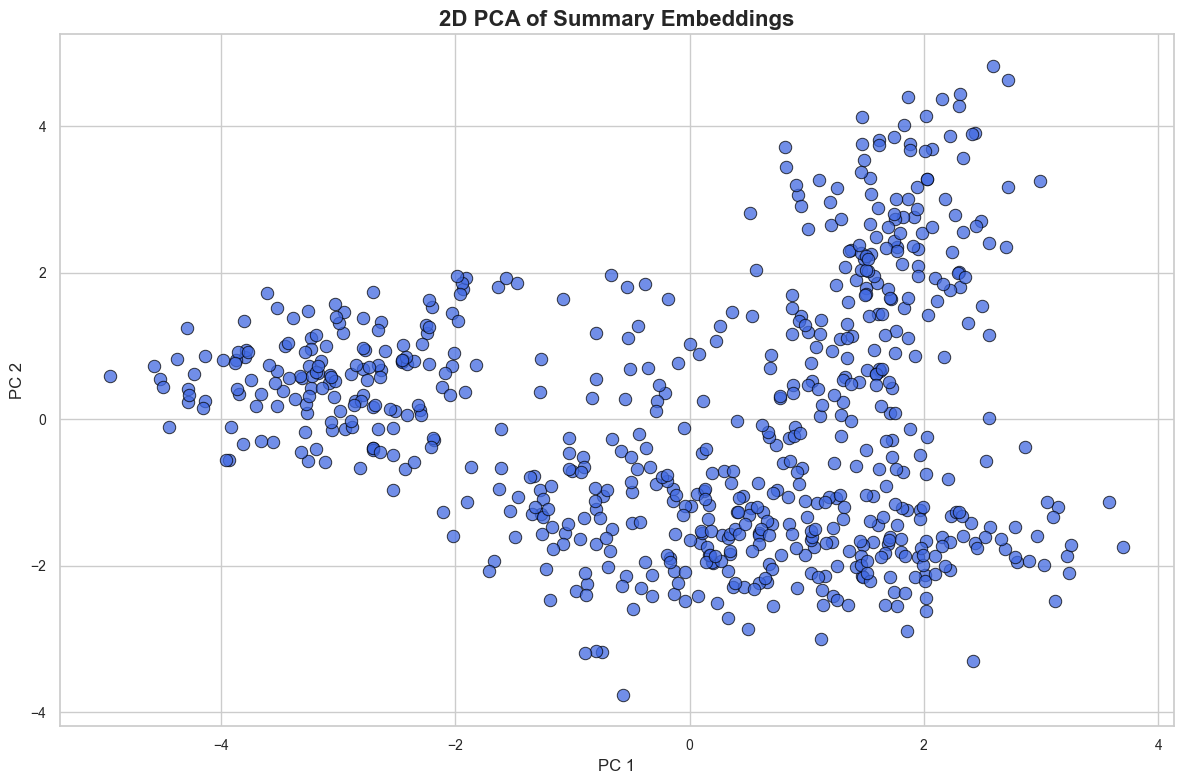

In [15]:
# PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(np.array(all_embeddings))

# Set style
sns.set(style="whitegrid", rc={"figure.figsize": (12, 8)})

# Plot
plt.figure()
sns.scatterplot(
    x=embeddings_2d[:, 0], 
    y=embeddings_2d[:, 1],
    s=80,
    alpha=0.75,
    edgecolor='black',
    color='royalblue'  # simple solid color
)
plt.title("2D PCA of Summary Embeddings", fontsize=16, weight='bold')
plt.xlabel("PC 1", fontsize=12)
plt.ylabel("PC 2", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

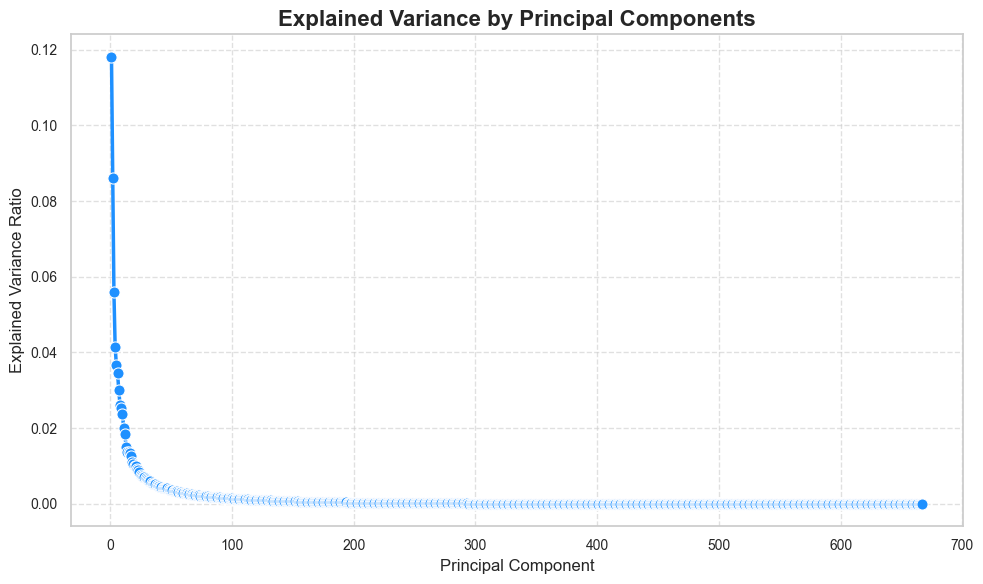

In [16]:
# PCA on all embeddings
pca = PCA()
pca.fit(np.array(all_embeddings))
explained_var = pca.explained_variance_ratio_

# Sort in descending order
explained_var_sorted = np.sort(explained_var)[::-1]

# Plot
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})
plt.figure()
sns.lineplot(
    x=np.arange(1, len(explained_var_sorted) + 1),
    y=explained_var_sorted,
    marker='o',
    linewidth=2.5,
    markersize=8,
    color='dodgerblue'
)
plt.title("Explained Variance by Principal Components", fontsize=16, weight='bold')
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Explained Variance Ratio", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()